In [6]:
# ===========================
# 1. Imports
# ===========================
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import models, transforms

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:

# ===========================
# 2. Dataset Setup
# ===========================
dataset_path = "/Users/linjheyu/.cache/kagglehub/datasets/undersc0re/fake-vs-real-face-classification/versions/5/train"
classes = ["real", "fake"]

# Preprocessing transforms for ResNet50
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:

# ===========================
# 3. Load ResNet50 pretrained
# ===========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
resnet = resnet.to(device)
resnet.eval()


/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [9]:

# ===========================
# 4. Extract embeddings
# ===========================
X = []
y = []
image_paths = []

# Count total images for tqdm
total_images = sum([len(os.listdir(os.path.join(dataset_path, c))) for c in classes])
pbar = tqdm(total=total_images, desc="Extracting embeddings")

for label_idx, label in enumerate(classes):
    folder = os.path.join(dataset_path, label)
    for img_name in os.listdir(folder):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).convert('RGB')
            img_tensor = preprocess(img).unsqueeze(0).to(device)

            with torch.no_grad():
                embedding = resnet(img_tensor)
                embedding = embedding.squeeze().cpu().numpy()

            X.append(embedding)
            y.append(label_idx)
            image_paths.append(img_path)

            pbar.update(1)

pbar.close()
X = np.array(X)
y = np.array(y)
print("Embeddings shape:", X.shape)



Extracting embeddings: 100%|██████████| 1197/1197 [02:34<00:00,  7.73it/s]

Embeddings shape: (1197, 2048)


In [10]:

# ===========================
# 5. PCA for dimensionality reduction
# ===========================
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)
print("PCA-transformed shape:", X_pca.shape)


PCA-transformed shape: (1197, 200)


In [11]:

# ===========================
# 6. Train/test split
# ===========================
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X_pca, y, image_paths, test_size=0.2, random_state=42
)

# ===========================
# 7. Random Forest Training
# ===========================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


Accuracy: 0.5333333333333333
F1-score: 0.28205128205128205

Classification Report:
               precision    recall  f1-score   support

        real       0.57      0.77      0.65       138
        fake       0.41      0.22      0.28       102

    accuracy                           0.53       240
   macro avg       0.49      0.49      0.47       240
weighted avg       0.50      0.53      0.50       240



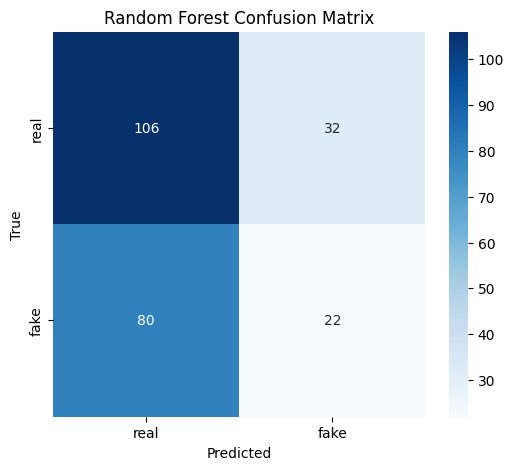

TP examples indices: [13 16 20 23]
TN examples indices: [ 2 10 11 14]
FP examples indices: [ 1  4  8 12]
FN examples indices: [0 3 5 6]


In [12]:
# ===========================
# 8. Evaluation
# ===========================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

# ===========================
# 9. Identify TP, TN, FP, FN indices
# ===========================
TP_idx = np.where((y_test == 1) & (y_pred == 1))[0]
TN_idx = np.where((y_test == 0) & (y_pred == 0))[0]
FP_idx = np.where((y_test == 0) & (y_pred == 1))[0]
FN_idx = np.where((y_test == 1) & (y_pred == 0))[0]

# Pick up to 4 examples from each
tp_examples = TP_idx[:4]
tn_examples = TN_idx[:4]
fp_examples = FP_idx[:4]
fn_examples = FN_idx[:4]

print("TP examples indices:", tp_examples)
print("TN examples indices:", tn_examples)
print("FP examples indices:", fp_examples)
print("FN examples indices:", fn_examples)


True Positive (Fake correctly predicted)


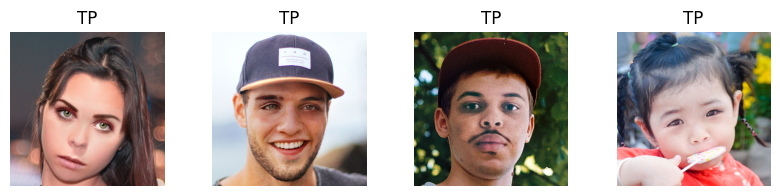

True Negative (Real correctly predicted)


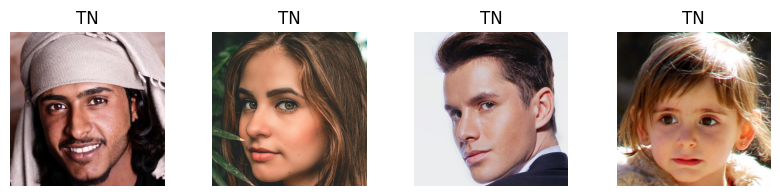

False Positive (Real predicted as Fake)


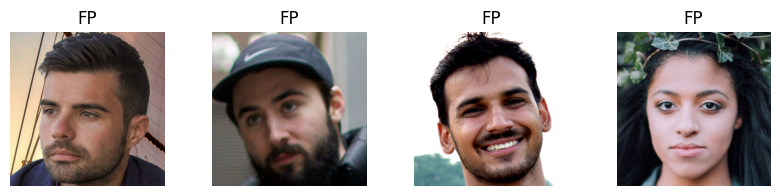

False Negative (Fake predicted as Real)


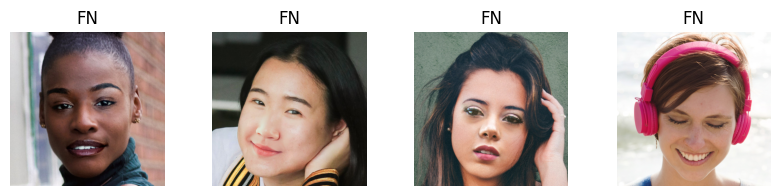

In [15]:

# ===========================
# 10. Display example images
# ===========================
def show_examples(indices, paths, title):
    plt.figure(figsize=(10,2))
    for i, idx in enumerate(indices):
        img_path = paths[idx]
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

print("True Positive (Fake correctly predicted)")
show_examples(tp_examples, paths_test, "TP")
print("True Negative (Real correctly predicted)")
show_examples(tn_examples, paths_test, "TN")
print("False Positive (Real predicted as Fake)")
show_examples(fp_examples, paths_test, "FP")
print("False Negative (Fake predicted as Real)")
show_examples(fn_examples, paths_test, "FN")